# Early Detection of Plant Diseases through Image Analysis
- Question: How can machine learning models use leaf images to accurately diagnose plant diseases at an early stage?
- Dataset: A dataset of leaf images labeled with different plant diseases.
 - Source: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data
- Method: Apply Convolutional Neural Networks (CNNs) to classify images into healthy or specific disease categories.

In [ ]:
# setup
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install torchsummary

Mounted at /content/drive


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import random

import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

In [ ]:
trainPath = "/content/drive/MyDrive/Colab Notebooks/205_FinalProject/data/New Plant Diseases Dataset(Augmented)/train"
validPath = "/content/drive/MyDrive/Colab Notebooks/205_FinalProject/data/New Plant Diseases Dataset(Augmented)/valid"
# function to remove .ipynb_checkpoints recursively
def remove_ipynb_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        for d in dirs:
            if d == '.ipynb_checkpoints':
                path = os.path.join(root, d)
                !rm -r "{path}"
remove_ipynb_checkpoints(trainPath)
remove_ipynb_checkpoints(validPath)

In [ ]:
classes = [c for c in os.listdir(trainPath)]
print(classes)
print("Total disease classes are: {}".format(len(classes)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']
Total disease classes are: 20


In [ ]:
classDict = {}
for c in classes:
    classDict[c] = len(os.listdir(trainPath + '/' + c))
classDF = pd.DataFrame(classDict.values(), index=classDict.keys(), columns=["no. of images"])
classDF

no. of images
Apple___Apple_scab                                           2016
Apple___Black_rot                                            1987
Apple___Cedar_apple_rust                                     1760
Apple___healthy                                              2008
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Corn_(maize)___Common_rust_                                  1907
Corn_(maize)___Northern_Leaf_Blight                          1908
Corn_(maize)___healthy                                       1859
Grape___Black_rot                                            1888
Grape___Esca_(Black_Measles)                                 1920
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Peach___Bacterial_spot                                       1838
Peach___healthy                                              1728
Pepper,_bell___Bacterial_spot                                1913
Pepper,_bell___healthy                                       1988

In [ ]:
plantList = []
numDiseases = 0
for c in classes:
    if c.split('___')[1] != 'healthy':
        numDiseases += 1
    if c.split('___')[0] not in plantList:
        plantList.append(c.split('___')[0])

print(f"Unique Plants are: \n{plantList}")
print("Number of plants: {}".format(len(plantList)))
print("Number of diseases: {}".format(numDiseases))

Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell']
Number of plants: 8
Number of diseases: 13


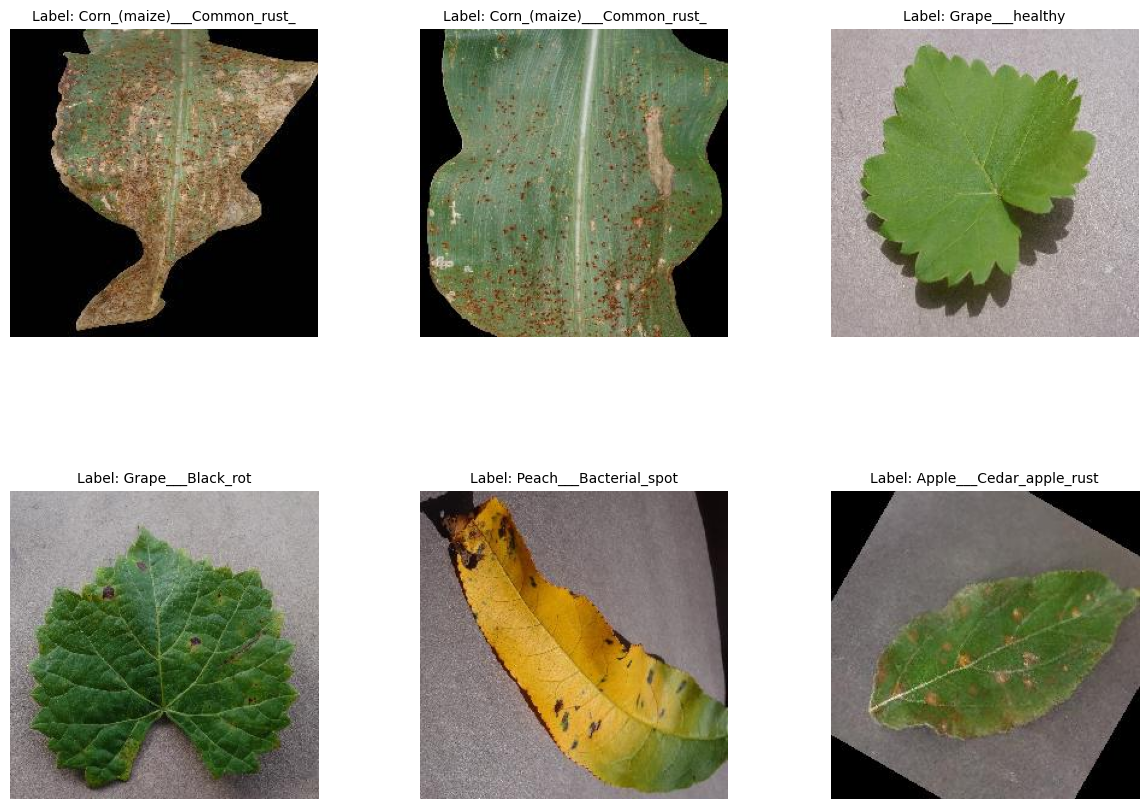

In [ ]:
train = ImageFolder(trainPath, transform = transforms.ToTensor())
valid = ImageFolder(validPath, transform = transforms.ToTensor())

def show_images(images, labels):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(zip(images, labels), start=1):
        plt.subplot(2, 3, i)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Label: " + train.classes[label], fontsize=10)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.5)
    plt.show()

num_samples = 6
random_indices = random.sample(range(len(train)), num_samples)
random_images = [train[i][0] for i in random_indices]
random_labels = [train[i][1] for i in random_indices]
show_images(random_images, random_labels)

In [ ]:
torch.manual_seed(25)
batchSize = 16
trainDataLoader = DataLoader(train, batchSize, shuffle=True, num_workers=4, pin_memory=True)
validDataLoader = DataLoader(valid, batchSize, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


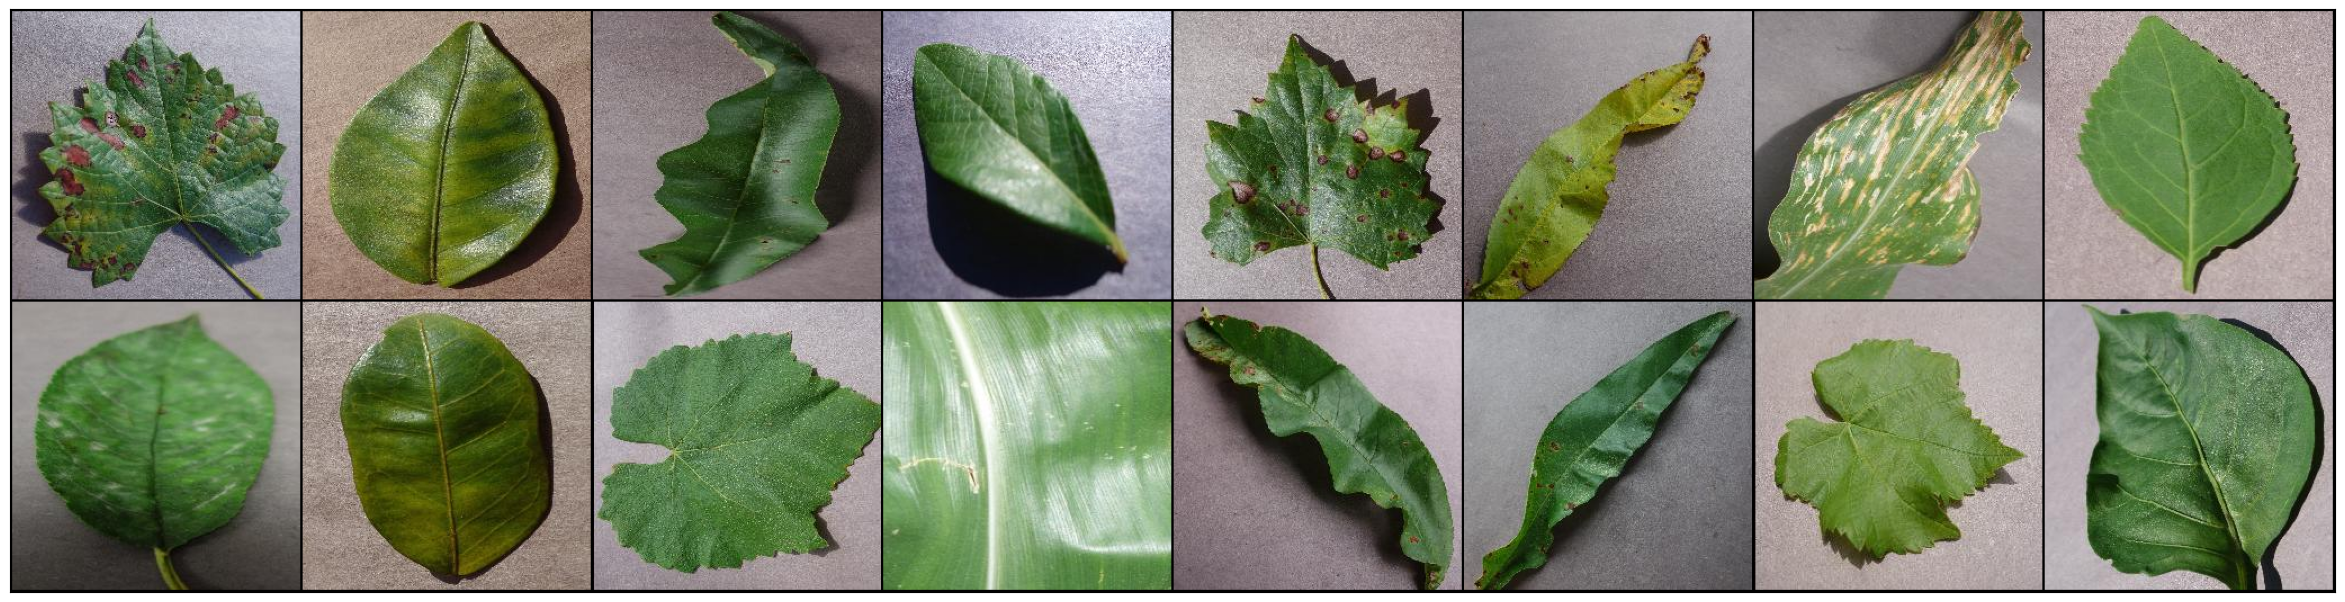

In [ ]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(trainDataLoader)

In [ ]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(train.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
print(summary(model.cuda(), ((3, 256, 256))))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
@torch.no_grad()
def evaluate(model, valDataLoader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valDataLoader]
    return model.validation_epoch_end(outputs)

def getLearningRate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fitCycle(epochs, maxLearningRate, model, trainDataLoader, valDataLoader, weightDecayFactor=0,
                gradientClippingVal=None, optimizerFunc=torch.optim.SGD):
    torch.cuda.empty_cache()
    evalRes = []
    optimizer = optimizerFunc(model.parameters(), maxLearningRate, weightDecayFactor=weightDecayFactor)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, maxLearningRate, epochs=epochs, steps_per_epoch=len(trainDataLoader))

    for epoch in range(epochs):
        model.train()
        trainLosses = []
        lrs = []
        for batch in trainDataLoader:
            loss = model.training_step(batch)
            trainLosses.append(loss)
            loss.backward()
            if gradientClippingVal:
                nn.utils.clip_grad_value_(model.parameters(), gradientClippingVal)

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(getLearningRate(optimizer))
            sched.step()
        result = evaluate(model, valDataLoader)
        result['train_loss'] = torch.stack(trainLosses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        evalRes.append(result)
    return evalRes

In [ ]:
trainDeviceDataLoader = DeviceDataLoader(trainDataLoader, device)
validDeviceDataLoader = DeviceDataLoader(validDataLoader, device)
evalRes = [evaluate(model, validDeviceDataLoader)]
evalRes

[{'val_loss': tensor(2.9969, device='cuda:0'), 'val_accuracy': tensor(0.0535)}]

In [ ]:
epochs = 2
maxLearningRate = 0.01
gradientClippingVal = 0.1
weightDecayFactor = 1e-4
optimizerFunc = torch.optim.Adam

In [ ]:
%%time
evalRes += fitCycle(epochs, maxLearningRate, model, trainDeviceDataLoader, validDeviceDataLoader,
                             gradientClippingVal=gradientClippingVal,
                             weightDecayFactor=1e-4,
                             optimizerFunc=optimizerFunc)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], last_lr: 0.00812, train_loss: 0.4090, val_loss: 0.2856, val_acc: 0.9075
Epoch [1], last_lr: 0.00000, train_loss: 0.1084, val_loss: 0.0176, val_acc: 0.9952
CPU times: user 4min 29s, sys: 4min 12s, total: 8min 41s
Wall time: 1h 6min 58s


In [ ]:
def plotAccuracy(evalRes):
    accuracies = [x['val_accuracy'] for x in evalRes]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plotLoss(evalRes):
    trainLosses = [x.get('train_loss').cpu().numpy() if isinstance(x.get('train_loss'), torch.Tensor) else x.get('train_loss') for x in evalRes]
    valLosses = [x['val_loss'].cpu().numpy() for x in evalRes]
    plt.plot(trainLosses, '-bx')
    plt.plot(valLosses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plotLRS(evalRes):
    lrs = np.concatenate([x.get('lrs', []) for x in evalRes])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

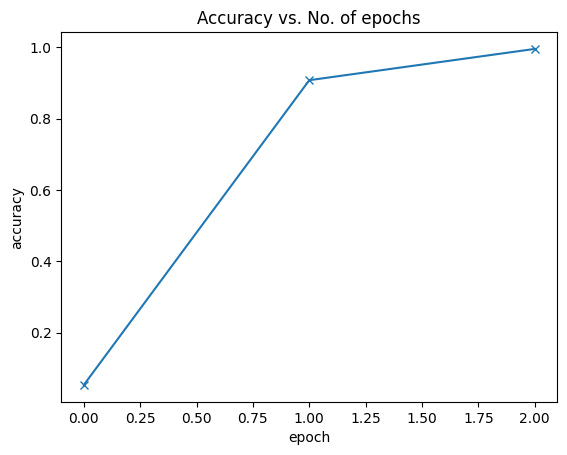

In [ ]:
plotAccuracy(evalRes)

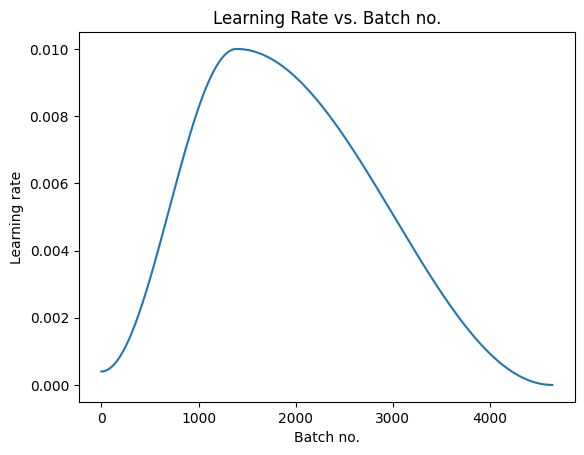

In [ ]:
plotLRS(evalRes)

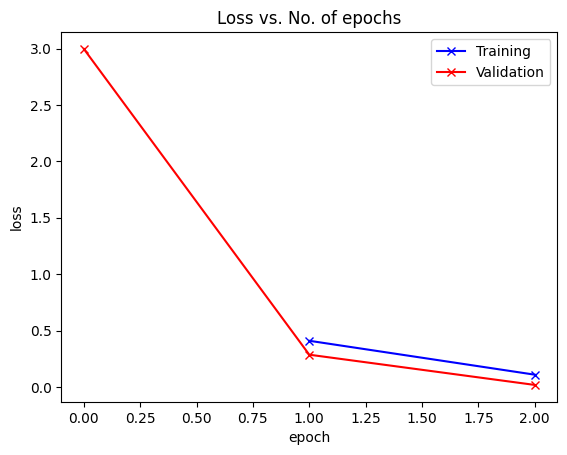

In [ ]:
plotLoss(evalRes)

In [ ]:
testPath = "/content/drive/MyDrive/Colab Notebooks/205_FinalProject/data/test"
testImages = sorted(os.listdir(testPath + '/test'))
testImages

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CherryMildew1.JPG',
 'CherryMildew2.JPG',
 'CherryMildew3.JPG',
 'CherryMildew4.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'GrapeBlackMeasles1.JPG',
 'GrapeBlackMeasles2.JPG',
 'GrapeBlackMeasles3.JPG',
 'GrapeHealthy1.jpg',
 'GrapeHealthy2.JPG',
 'GrapeHealthy3.JPG',
 'OrangeCitrus1.JPG',
 'OrangeCitrus2.JPG',
 'OrangeCitrus3.JPG',
 'PeachBacterialSpot1.JPG',
 'PeachBacterialSpot2.JPG',
 'PeachBacterialSpot3.JPG',
 'PepperbellBacterialSpot1.JPG',
 'PepperbellBacterialSpot2.JPG',
 'PepperbellBacterialSpot3.JPG',
 'PepperbellBacterialSpot4.JPG',
 'PepperbellHealthy1.JPG',
 'PepperbellHealthy2.JPG',
 'PepperbellHealthy3.JPG']

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


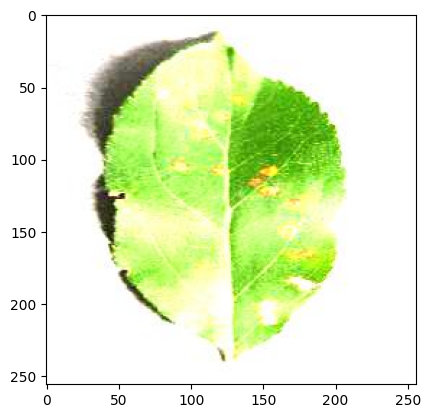

In [ ]:
def predict_image(img, model):
    _, predictions  = torch.max(model(to_device(img.unsqueeze(0), device)), dim=1)
    return train.classes[predictions[0].item()]

testIF = ImageFolder(testPath, transform = transforms.ToTensor())
img, label = testIF[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', testImages[0], ', Predicted:', predict_image(img, model))

In [ ]:
for i, (img, label) in enumerate(testIF):
    print('Label:', testImages[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CherryMildew1.JPG , Predicted: Cherry_(including_sour)___Powdery_mildew
Label: CherryMildew2.JPG , Predicted: Cherry_(including_sour)___Powdery_mildew
Label: CherryMildew3.JPG , Predicted: Cherry_(including_sour)___Powdery_mildew
Label: CherryMildew4.JPG , Predicted: Cherry_(including_sour)___Powdery_mildew
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: GrapeBlackMeasles1.JPG , Predicted: Grape___Esca_(B

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/205_FinalProject/data/test'

# Save the model
torch.save(model.state_dict(), path)